 # **Human Metagenomics: Exploratory Data Analysis For Diabetes** 

# Introduction

The Abundance data contains both metadata and information on the microbial species found in each sample. 8 publicly available metagenomic datasets were used to create the file. The authors applied MetaPhlAn2 to generate species abundance features. MetaPhlan2 utilizes a database of phylogenetic clade-specific markers to assign metagenomic sequences to specific taxonomic groups. 

The authors investigated which ML methods were best used to classify specific diseases based on the species abundance features. Unfortunately, it was difficult for them to predict diabetes with their Random Forest or XG Boost models. My goal is to find a better model or approach to predict diabetes. In this notebook, I will provide an exploratory data analysis.   

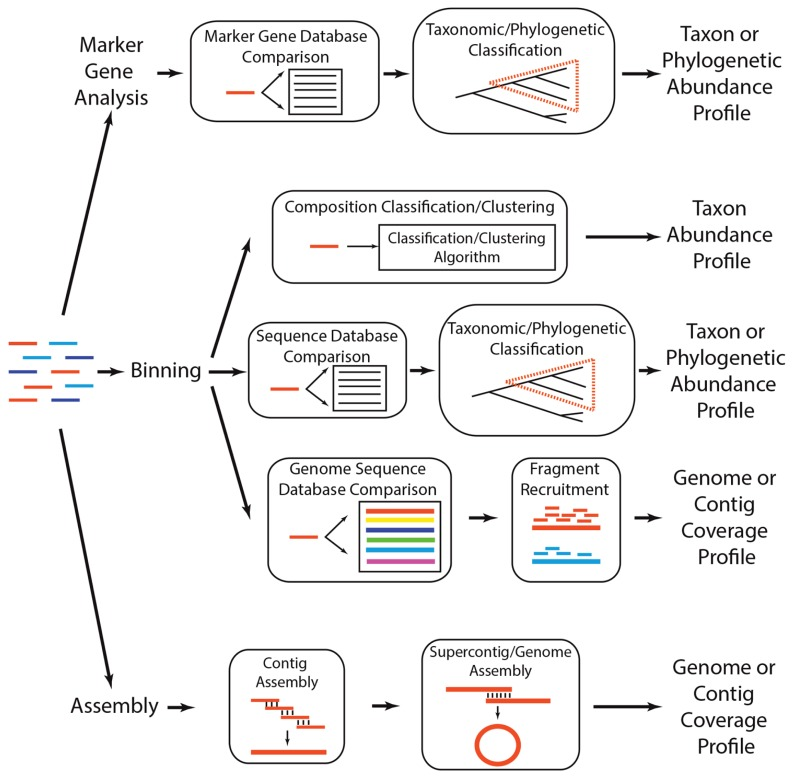

# Import Libraries and Data

In [ ]:
import numpy as np 
import pandas as pd 
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

In [ ]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
abundance = pd.read_csv('/kaggle/input/human-metagenomics/abundance.csv')

In [ ]:
abundance.head()

# Cleaning Data

After subsetting the abundance.csv to the three datatsets that were relevant to diabetes, I removed all unimformative variables from the dataset. There were plenty of variables in the metadata with no records for any of the samples.

While cleaning the data, I also noticed a few redundant variables. Since the metadata was collected from two seperate diabetes studies (WT2D and t2dmeta), there were cases where there were two different variables that represented the same metric. One example of this, with the variables **'Triglycerides'** and **'tg'** from WT2D and t2dmeta respectively and both measure triglycerides levels in mmol/L. I used the information provided in the supplements of the two original studies https://www.nature.com/articles/nature12198 and https://www.nature.com/articles/nature11450 to come to this conclusion. For cases like this, I attempted merge the information together to one variable.

In [ ]:
for col in abundance.columns: 
    print(col) 

In [ ]:
#Finding the unique values of disease for all datasets
abundance.groupby('dataset_name')['disease'].unique()
#the value t2d means type 2 diabetes
#There are only three datasets are revelant to diabetes 'WT2D','t2dmeta_long','t2dmeta_short'.'WT2D','t2dmeta_long','t2dmeta_short'.

In [ ]:
#grouping all of the diabetes datasets together
abundance_diabetes=abundance.loc[(abundance.dataset_name=='WT2D') | (abundance.dataset_name=='t2dmeta_long')|
                       (abundance.dataset_name=='t2dmeta_short'),:]
#changes all missing values to nan
abundance_diabetes = abundance_diabetes.replace('nd',np.nan).replace('na',np.nan).replace('-',np.nan).replace(' -',np.nan)
abundance_diabetes.shape

In [ ]:
#divided the abundance data to metadata and species data
split_index=abundance.columns.get_loc('k__Archaea')
diabetes_metadata=abundance_diabetes.iloc[:,0:split_index]
diabetes_species=abundance_diabetes.iloc[:,split_index:]

In [ ]:
#finding the columns with entry as na 
cols = (  diabetes_metadata.isna().sum()  !=  len(diabetes_metadata)  )
#deleting the columns with every entry as na
diabetes_metadata_short =diabetes_metadata[cols[cols].index]
diabetes_metadata_short.shape

In [ ]:
for col in diabetes_metadata_short.columns: 
    print(col) 

In [ ]:
#get rid of more redundant and unnecessary variables in metadata
unimport =['subjectID', 'sequencing_technology', 'pubmedid','#SampleID',
           'diabetic','bodysite','classification']
diabetes_metadata_short=diabetes_metadata_short.drop(columns= unimport)
diabetes_metadata_short.shape

In [ ]:
(diabetes_species < 0).values.any()
#all values for species are zero or positive

In [ ]:
#finding the columns with max entry to zero to remove unimformative variables
# All values for species >=0, so a column with a max entry of zero means has all zeroes
cols = (  diabetes_species.max()  !=  0 )
#subseting the species data to informative variables
diabetes_species_short =diabetes_species[cols[cols].index]
diabetes_species_short.shape

In [ ]:
for col in diabetes_species_short.columns: 
    print(col) 

In [ ]:
#merge the metadata and species data together after filtering out uninformative variables
diabetes_short=diabetes_metadata_short.join(diabetes_species_short)
diabetes_short.head()

In [ ]:
#all of the continuous and discrete variables in the metadata
num_var=['age','bmi','height','weight','fbg','sbp','dbp','fins','fcp','hbalc','tg',
        'tcho','hdl','ldl','whr','wc','cholesterol','triglycerides','creatinine',
         'y-gt','fasting_glucose','fasting_insulin','hba1c','hscrp','c-peptide','tnfa',
         'il-1','cd163','years_in_sweden','glp-1','fgf-19','leptin','adiponectin',
         'gad-antibodies']
#converts all of the continuous and discrete variables to numeric 
diabetes_short.loc[:,num_var] = diabetes_short.loc[:,num_var].apply(pd.to_numeric, errors='coerce', axis=1)

In [ ]:
# replaces the missing values in cholesterol with tcho values
# tcho and cholesterol are from WT2D and T2Dmeta respectively and they both represent
# total cholesterol
s = diabetes_short['sampleID'].map(diabetes_short.set_index('sampleID')['tcho'])
diabetes_short['cholesterol']= diabetes_short['cholesterol'].mask(diabetes_short['cholesterol'].isnull(), s)


 I noticed a unique issue with the variables **'hba1c'** and **'hbalc'**. **'hba1c'** and **'hbalc'** , which are from the studies WT2D and t2dmeta, respectively. They both represent the amount of glycosylated hemogoblin A1C, but the main difference between these variables is the metrics they use. **'hba1c'** is measured in mmol/mol with values ranging from 26 to  77. **hbalc** is measured as a pecentage with values ranging from 4.2 to 13.8. There doesn't seem to be a clean way to convert one variable to the other metric.

In [ ]:
print("hba1c has a mininum",np.nanmin(diabetes_short['hba1c']),'and maximum of',
      np.nanmax(diabetes_short['hba1c'])  )

In [ ]:
print("hbalc has a mininum",np.nanmin(diabetes_short['hbalc']),'and maximum of', 
      np.nanmax(diabetes_short['hbalc'])  )

In [ ]:
# replaces the missing values in fasting_glucose with fbg values
# fasting_glucose and fbg are from WT2D and T2Dmeta respectively and they both represent
# fasting blood glucose
s = diabetes_short['sampleID'].map(diabetes_short.set_index('sampleID')['fbg'])
diabetes_short['fasting_glucose']= diabetes_short['fasting_glucose'].mask(diabetes_short['fasting_glucose'].isnull(), s)

In [ ]:
# replaces the missing values in triglycerides with tg values
# triglycerides and tg are from WT2D and T2Dmeta respectively and they both represent
# Triglyceride levels
s = diabetes_short['sampleID'].map(diabetes_short.set_index('sampleID')['tg'])
diabetes_short['triglycerides']= diabetes_short['triglycerides'].mask(diabetes_short['triglycerides'].isnull(), s)

In [ ]:
# replaces the missing values in fasting_insulin with fins values
# fasting_insulin and fins (Fasting Insulin Serum) are from WT2D and T2Dmeta respectively and they both represent
# fasting insulin serum
s = diabetes_short['sampleID'].map(diabetes_short.set_index('sampleID')['fins'])
diabetes_short['fasting_insulin']= diabetes_short['fasting_insulin'].mask(diabetes_short['fasting_insulin'].isnull(), s)

From exploring the data, I found the gender variable had missing values for every observation in the WT2D dataset. According to the paper for the WT2D https://www.nature.com/articles/nature12198 , all of the participants were women. Therefore, we can replace these missing values with the label "female".

In [ ]:
diabetes_short.loc[diabetes_short.dataset_name=="WT2D"].gender
#gender is not recorded for the WT2D data b/c it was a study conducted on only women.

In [ ]:
#gender is not recorded for the WT2D data b/c it was a study conducted on only women.
#replace all nas with female in WT2D
mask1 = (diabetes_short.dataset_name=="WT2D") & (diabetes_short.gender.isna())
diabetes_short.loc[mask1, 'gender'] = 'female'

In [ ]:
redundant =['tcho','fbg','fins','tg']
diabetes_short=diabetes_short.drop(columns= redundant)
diabetes_short.shape

In [ ]:
diabetes_short2=diabetes_short

# Data Description

I have provided a table explaining the meaning of some of the abbreviations used for  variable names for the metadata.

| Abbreviations            | Meaning            |
| ----------------------- | ------------------- | 
|bmi| Body mass index| 
|sbp  |    Systolic blood pressure  |
|dbp    | Diastolic blood pressure|
|tg   |  Triglycerides                 |
|tcho | Total Cholesterol |
|fins | Fasting Insulin Serum |
|fbg  | Fasting Blood Glucose|
|hdl |    High density lipoprotein|
|ldl |    Low density lipoprotein|
|gad-antibodies |    Glutamic acid decarboxylase antibodies|            
|whr |    Waist-to-hip ratio|        
|wc |    Waist circumference|        
|y-gt |    $\gamma$ -glutamyltransferase|        
|hba1c |    Glycosylated hemoglobin A1c ($\%$)|
|hbalc |    Glycosylated hemoglobin A1c (mmol/mol)| 
|glp-1 |    Glucagon-like peptide 1    |        
|fgf-19 |    Fibroblast growth factor 19 |    
|hscrp |    High-sensitivity C-reactive protein|    
|tnfa |    Tumor necrosis factor $\alpha$|        
|il-1 |    Interleukin 1|             
|cd163 |    Cluster of differentiation 163|                                             |

The outcome variable of interest is **'disease'** which as three categories **'t2d'** (Type 2 Diabetes), **'impaired_glucose_tolerance'** (Pre-Diabetes), and **'n'** (No Type 2 Diabetes). The datasets t2dmeta_long and t2dmeta_short has disease outcome  labeled as **'t2d'** and **'n'** while dataset WT2D has disease labeled as **'n'** or **'t2d'** or **'impaired_glucose_tolerance'**.

The species data has variable names with a pattern like: $ k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae
|g__Bacteroides|s__Bacteroides_caccae $

I have broken down the meaning of each section of the variable name in the table below.

| Section          | Meaning    
| ----------------------- | ------------------- | 
|   k__Bacteria      | Bacteria Kingdom           |              
|p__Bacteroidetes    |  Bacteriodetes Phylum           |    
|    c__Bacteroidia     |  Bacteroidia Class | 
|  f__Bacteroidaceae       | Bacteroidaceae Family     | 
| g__Bacteroides    | Bacteroides Genus              |
| s__Bacteroides_caccae         | Bacteroides caccae Species             | 


The variable:

$ k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae
|g__Bacteroides|s__Bacteroides_caccae $

represents the number of reads for the Bacteroides cacae species for each sample.

# Exploratory Graphs

I created histograms and box plots of the numeric variables in order to investigated their relationship to the outcome of disease.

In [ ]:
diabetes_short=diabetes_short.replace(['n','impaired_glucose_tolerance',"t2d"],['No Diabetes','Pre-Diabetes',"Type 2 Diabetes"])

In [ ]:
#diabetes_short.groupby('disease')['age'].plot(kind='hist', figsize=(15, 5), alpha=0.5, bins=50)
sns.displot(x='age',hue= "disease",data=diabetes_short)
#graphing a histogram by disease
plt.xlabel('Age')
plt.title('Histogram of the Age Grouped by Disease')
plt.legend()
plt.show()

In [ ]:
sns.boxplot(y='age',x= "disease",data=diabetes_short)
#graphing a histogram by disease
plt.xlabel('Age')
plt.title('Histogram of the Age Grouped by Disease')
plt.legend()
plt.show()

In [ ]:
#diabetes_short.groupby('disease')['cholesterol'].plot(kind='hist', figsize=(15, 5), alpha=0.5, bins=50)
sns.displot(x='cholesterol',hue= "disease",data=diabetes_short,
            hue_order=['No Diabetes','Pre-Diabetes',"Type 2 Diabetes"])
#histogram  by disease
plt.xlabel('Cholesterol, mmol/L ')
plt.title('Histogram of the Total Cholesterol Grouped by Disease',fontsize=20)
plt.legend()
plt.show()

According to the histograms, it looks like total cholesterol has a normal distribution across all disease categories.

In [ ]:
#diabetes_short.groupby('disease')['c-peptide'].plot(kind='hist', figsize=(15, 5), alpha=0.5, bins=50)
sns.displot(x='c-peptide',hue= "disease",data=diabetes_short)
#graphing a histogram 
plt.xlabel('Serum C-peptide, nmol/L')
plt.title('Histogram of the c-peptide Grouped by Disease')
plt.legend()
plt.show()

In [ ]:
#diabetes_short.groupby('disease')['fasting_glucose'].plot(kind='hist', figsize=(15, 5), alpha=0.5,bins=30)
sns.displot(x='fasting_glucose',hue= "disease",data=diabetes_short,
            hue_order=['No Diabetes','Pre-Diabetes',"Type 2 Diabetes"],legend=False)
#graphing a histogram 
plt.xlabel('Fasting Blood Glucose mmol/L')
plt.title('Histogram of the Fasting Blood Glucose Grouped by Disease',fontsize=20)
plt.legend(labels=["Type 2 Diabetes",'Pre-Diabetes','No Diabetes'])
plt.show()

In [ ]:
sns.boxplot(y='fasting_glucose',x='disease', data=diabetes_short,
           order=['No Diabetes','Pre-Diabetes',"Type 2 Diabetes"])
plt.ylabel('Fasting Blood Glucose mmol/L')
plt.title('Box Plot of the Fasting Blood Glucose Grouped by Disease',fontsize=20)
plt.legend()
plt.show()

From looking at the histograms, fasting blood glucose more skewed to the right for the non-diabetic and pre-diabetic group compared to diabetic group. The boxplots also show that most Type 2 Diabetes patients on average have higher glucose levels. This makes sense because high blood glucose usually correlates with diabetes. 

In [ ]:
#diabetes_short.groupby('disease')['fasting_glucose'].plot(kind='hist', figsize=(15, 5), alpha=0.5,bins=30)
sns.displot(x='fasting_glucose',hue= "disease",data=diabetes_short[diabetes_short.dataset_name!="WT2D"])
#graphing a histogram 
plt.xlabel('Fasting Blood Glucose mmol/L')
plt.title('Histogram of the Fasting Blood Glucose Grouped by Disease')
plt.legend()
plt.show()

In [ ]:
#diabetes_short.groupby('disease')['fasting_insulin'].plot(kind='hist', figsize=(15, 5), alpha=0.5, bins=50)
sns.displot(x='fasting_insulin',hue= "disease",data=diabetes_short)
#graphing a histogram 
plt.xlabel('Fasting Insulin')
plt.title('Histogram of the Fasting Insulin Grouped by Disease')
plt.legend()
plt.show()

In [ ]:
#diabetes_short.groupby('disease')['hba1c'].plot(kind='hist', figsize=(15, 5), alpha=0.5, bins=30)
sns.displot(x='hba1c',hue= "disease",data=diabetes_short[diabetes_short.dataset_name!="WT2D"])
#graphing a histogram 
plt.xlabel('HbA1c, mmol/mol')
plt.title('Histogram of the HbA1c Grouped by Disease')
plt.legend()
plt.show()

In [ ]:
sns.displot(x='hba1c',hue= "disease",data=diabetes_short,
            hue_order=['No Diabetes','Pre-Diabetes',"Type 2 Diabetes"])
#graphing a histogram 
plt.xlabel('HBA1C, mmol/mol')
plt.title('Histogram of the HBA1C mmol/mol for the dataset WT2D',fontsize=20)
plt.legend()
plt.show()

In [ ]:
sns.boxplot(y='hba1c',x='disease', data=diabetes_short,
            order=['No Diabetes','Pre-Diabetes',"Type 2 Diabetes"])
#graphing a histogram 
plt.ylabel('hba1c mmol/mol')
#labels=['No Diabetes','Pre-Diabetes',"Type 2 Diabetes"]
plt.title('Boxplot of the HBA1C mmol/mol for the dataset WT2D',fontsize=20)
plt.legend()
plt.show()


The relationships shows that HBA1C (Glycosylated hemoglobin A1c meausred in mmol/mol) increases with the level of severity of diabetes with the WT2D dataset

In [ ]:
sns.displot(x='hbalc',hue= "disease",data=diabetes_short,
            hue_order=['No Diabetes','Pre-Diabetes',"Type 2 Diabetes"])
#graphing a histogram 
plt.xlabel('HBAlC (%)')
plt.title('Histogram of the HBA1C (%) for the datasets T2Dmeta', fontsize=20 )
plt.legend()
plt.show()

In [ ]:
sns.boxplot(y='hbalc',x='disease', data=diabetes_short,
            order=['No Diabetes','Pre-Diabetes',"Type 2 Diabetes"])
#graphing a histogram 
plt.ylabel('hba1c (%)')
#labels=['No Diabetes','Pre-Diabetes',"Type 2 Diabetes"]
plt.title('Boxplot of the HBA1C (%) for the datasets T2Dmeta',fontsize=20 )
plt.legend()
plt.show()

The relationships shows that HBA1C (Glycosylated hemoglobin A1c meausred as a percentage) is higher in diabetics than patients with no diabetes for the T2Dmeta datasets.

In [ ]:
#diabetes_short.groupby('disease')['weight'].plot(kind='hist', figsize=(15, 5), alpha=0.5, bins=50)
sns.displot(x='weight',hue= "disease",data=diabetes_short)
#graphing a histogram of the bmi by group datasets
plt.xlabel('weight')
plt.title('Histogram of the Weight Grouped by Disease')
plt.legend()
plt.show()

In [ ]:
sns.boxplot(y='fasting_insulin',x='disease', data=diabetes_short)

plt.ylabel('Fasting Insulin')
plt.title('Boxplot of the Fasting Insulin Grouped by Disease')
plt.legend()
plt.show()

In [ ]:
#diabetes_short.groupby('disease')['triglycerides'].plot(kind='hist', figsize=(15, 5), alpha=0.5, bins=50)
sns.displot(x='triglycerides',hue= "disease",data=diabetes_short)
#graphing a histogram 
plt.xlabel('Triglycerides')
plt.title('Histogram of the Triglycerides Grouped by Disease')
plt.legend()
plt.show()

In [ ]:
#diabetes_short.groupby('disease')['sbp'].plot(kind='hist', figsize=(15, 5), alpha=0.5, bins=50)
sns.displot(x='sbp',hue= "disease",data=diabetes_short)
#graphing a histogram 
plt.xlabel('sbp')
plt.title('Histogram of the Systolic Blood Pressure Grouped by Disease')
plt.legend()
plt.show()

In [ ]:
#diabetes_short.groupby('disease')['dbp'].plot(kind='hist', figsize=(15, 5), alpha=0.5, bins=50)
sns.displot(x='dbp',hue= "disease",data=diabetes_short)
#graphing a histogram 
plt.xlabel('dbp')
plt.title('Histogram of the Diastolic Blood Pressure Grouped by Disease')
plt.legend()
plt.show()

In [ ]:
#diabetes_short.groupby('disease')['fcp'].plot(kind='hist', figsize=(15, 5), alpha=0.5, bins=50)
sns.displot(x='fcp',hue= "disease",data=diabetes_short)
#graphing a histogram 
plt.xlabel('fcp')
plt.title('Histogram of the Fasting C-Peptide Grouped by Disease')
plt.legend()
plt.show()

In [ ]:
#diabetes_short.groupby('disease')['hdl'].plot(kind='hist', figsize=(15, 5), alpha=0.5, bins=50)
sns.displot(x='hdl',hue= "disease",data=diabetes_short)
#graphing a histogram 
plt.xlabel( 'HDL Cholesterol mmol/L')
plt.title('Histogram of the HDL Cholesterol Grouped by Disease')
plt.legend()
plt.show()

In [ ]:
sns.displot(x='hdl',hue= "disease",data=diabetes_short)
#graphing a histogram 
plt.xlabel( 'HDL Cholesterol mmol/L')
plt.title('Histogram of the HDL Cholesterol Grouped by Disease')
plt.legend()
plt.show()

In [ ]:
#diabetes_short.groupby('disease')['ldl'].plot(kind='hist', figsize=(15, 5), alpha=0.5, bins=50)
#graphing a histogram 
sns.displot(x='ldl',hue= "disease",data=diabetes_short)
plt.xlabel( 'LDL Cholesterol mmol/L')
plt.title('Histogram of the LDL Cholesterol Grouped by Disease')
plt.legend()
plt.show()

In [ ]:
sns.boxplot(y='ldl',x='disease', data=diabetes_short)
#graphing a histogram 
plt.xlabel( 'LDL Cholesterol mmol/L')
plt.title('Histogram of the LDL Cholesterol Grouped by Disease')
plt.legend()
plt.show()

In [ ]:
#diabetes_short.groupby('disease')['whr'].plot(kind='hist', figsize=(15, 5), alpha=0.5, bins=50)
sns.displot(x='ldl',hue= "disease",data=diabetes_short)
#graphing a histogram
plt.xlabel('Waist to Hip Ratio')
plt.title('Histogram of the Waist to Hip Ratio Grouped by Disease')
plt.legend()
plt.show()

In [ ]:
#diabetes_short.groupby('disease')['wc'].plot(kind='hist', figsize=(15, 5), alpha=0.5, bins=50)
sns.displot(x='wc',hue= "disease",data=diabetes_short)
#graphing a histogram 
plt.xlabel('Waist Circumference')
plt.title('Histogram of the Waist Circumference Grouped by Disease')
plt.legend()
plt.show()

In [ ]:
#diabetes_short.groupby('disease')['creatinine'].plot(kind='hist', figsize=(15, 5), alpha=0.5, bins=50)
sns.displot(x='creatinine',hue= "disease",data=diabetes_short)
#graphing a histogram of the bmi by group datasets
plt.xlabel('Creatinine')
plt.title('Histogram of the Creatinine Grouped by Disease')
plt.legend()
plt.show()

In [ ]:
#diabetes_short.groupby('disease')['y-gt'].plot(kind='hist', figsize=(15, 5), alpha=0.5, bins=50)
sns.displot(x='y-gt',hue= "disease",data=diabetes_short)
#graphing a histogram 
plt.xlabel('y-glutamyltransferase ')
plt.title('Histogram of the Y-Glutamyltransferase Grouped by Disease')
plt.legend()
plt.show()

In [ ]:
ax=sns.boxplot(y='y-gt',x='disease', data=diabetes_short)
ax.set_yscale('log')
plt.xlabel('disease')
plt.title('Boxplot of the Y-Glutamyltransferase Grouped by Disease')
plt.legend()
plt.show()

In [ ]:

#diabetes_short.groupby('disease')['hscrp'].plot(kind='hist', figsize=(15, 5), alpha=0.5, bins=50)
sns.displot(x='hscrp',hue= "disease",data=diabetes_short)
#graphing a histogram of the bmi by group datasets
plt.xlabel('High-sensitivity C-reactive Protein')
plt.title('Histogram of the High-sensitivity C-reactive Protein Grouped by Disease')
plt.legend()
plt.show()

In [ ]:
ax=sns.boxplot(y='hscrp',x='disease', data=diabetes_short)
ax.set_yscale('log')
plt.xlabel('disease')
plt.title('Boxplot of the High-sensitivity C-reactive Protein Grouped by Disease')
plt.legend()
plt.show()

In [ ]:

#diabetes_short.groupby('disease')['tnfa'].plot(kind='hist', figsize=(15, 5), alpha=0.5, bins=50)
sns.displot(x='tnfa',hue= "disease",data=diabetes_short)
#graphing a histogram of the bmi by group datasets
plt.xlabel('Tumor Necrosis Factor Alpha')
plt.title('Histogram of the Tumor Necrosis Factor Alpha Grouped by Disease')
plt.legend()
plt.show()

In [ ]:

#diabetes_short.groupby('disease')['il-1'].plot(kind='hist', figsize=(15, 5), alpha=0.5, bins=50)
sns.displot(x='il-1',hue= "disease",data=diabetes_short)
#graphing a histogram of the bmi by group datasets
plt.xlabel('Interleukin 1')
plt.title('Histogram of the Interleukin 1 Grouped by Disease')
plt.legend()
plt.show()

In [ ]:
#diabetes_short.groupby('disease')['cd163'].plot(kind='hist', figsize=(15, 5), alpha=0.5, bins=50)
sns.displot(x='cd163',hue= "disease",data=diabetes_short)
#graphing a histogram of the bmi by group datasets
plt.xlabel('Cluster of Differentiation 163')
plt.title('Histogram of the Cluster of Differentiation 163 Grouped by Disease')
plt.legend()
plt.show()

In [ ]:
#diabetes_short.groupby('disease')['glp-1'].plot(kind='hist', figsize=(15, 5), alpha=0.5, bins=50)
sns.displot(x='glp-1',hue= "disease",data=diabetes_short)
#graphing a histogram of the bmi by group datasets
plt.xlabel('Cluster of Glucagon-like Peptide')
plt.title('Histogram of the Glucagon-like Peptide Grouped by Disease')
plt.legend()
plt.show()

In [ ]:
#diabetes_short.groupby('disease')['fgf-19'].plot(kind='hist', figsize=(15, 5), alpha=0.5, bins=50)
sns.displot(x='fgf-19',hue= "disease",data=diabetes_short)
#graphing a histogram of the bmi by group datasets
plt.xlabel('Fibroblast Growth Factor 19')
plt.title('Histogram of the Fibroblast Growth Factor 19 Grouped by Disease')
plt.legend()
plt.show()

In [ ]:

#diabetes_short.groupby('disease')['leptin'].plot(kind='hist', figsize=(15, 5), alpha=0.5, bins=50)
sns.displot(x='leptin',hue= "disease",data=diabetes_short)
#graphing a histogram 
plt.xlabel('Leptin')
plt.title('Histogram of Leptin Grouped by Disease')
plt.legend()
plt.show()

In [ ]:

#diabetes_short.groupby('disease')['adiponectin'].plot(kind='hist', figsize=(15, 5), alpha=0.5, bins=50)
sns.displot(x='adiponectin',hue= "disease",data=diabetes_short)
#graphing a histogram 
plt.xlabel('Adiponectin')
plt.title('Histogram of Adiponectin Grouped by Disease')
plt.legend()
plt.show()

In [ ]:
#diabetes_short.groupby('disease')['gad-antibodies'].plot(kind='hist', figsize=(15, 5), alpha=0.5, bins=50)
sns.histplot(x='gad-antibodies',hue= "disease",data=diabetes_short)
#graphing a histogram 
plt.xlabel('Gad-Antibodies')
plt.title('Histogram of Gad-Antibodies Grouped by Disease')
plt.legend()
plt.show()

In [ ]:
sns.violinplot(x='disease',y='k__Bacteria',data=diabetes_short)
plt.xlabel('disease')
plt.title('Violin Plot of the Bacteria Kingdom Grouped by Disease')
plt.legend()
plt.show()

In [ ]:
diabetes_short.groupby('disease')['k__Bacteria|p__Actinobacteria'].plot(logy=True,kind='hist', figsize=(15, 5), alpha=0.5, bins=50)
#graphing a histogram 
plt.xlabel('Actinobacteria')
plt.title('Histogram of the Actinobacteria Phylum Grouped by Disease')
plt.legend()
plt.show()

In [ ]:

diabetes_short.groupby('disease')['k__Eukaryota'].plot(kind='hist', figsize=(15, 5), alpha=0.5, bins=50)
#graphing a histogram 
plt.xlabel('Eukaryota')
plt.title('Histogram of the Eukaryota Kingdom Grouped by Disease')
plt.legend()
plt.show()

In [ ]:

diabetes_short.groupby('disease')['k__Bacteria|p__Synergistetes|c__Synergistia'].plot(logy=True,kind='hist', figsize=(15, 5), alpha=0.5, bins=50)
#graphing a histogram
plt.xlabel('Synergistia')
plt.title('Histogram of the Synergistia class Grouped by Disease')
plt.legend()
plt.show()


In [ ]:



diabetes_short.groupby('disease')['k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus|s__Ruminococcus_sp_5_1_39BFAA'].plot(logy=True,kind='hist', figsize=(15, 5), alpha=0.5, bins=50)
#graphing a histogram
plt.xlabel('Ruminococcus_sp_5_1_39BFAA')
plt.title('Histogram of the Ruminococcus_sp_5_1_39BFAA Species Grouped by Disease')
plt.legend()
plt.show()


In [ ]:
diabetes_short.groupby('disease')['k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_symbiosum'].plot(logy=True,kind='hist', figsize=(15, 5), alpha=0.5, bins=50)
#graphing a histogram
plt.xlabel('Species')
plt.title('Histogram of the Species Grouped by Disease')
plt.legend()
plt.show()


In [ ]:

diabetes_short.groupby('disease')['k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Escherichia|s__Escherichia_coli'].plot(logy=True,kind='hist', figsize=(15, 5), alpha=0.5, bins=50)
plt.xlabel('Species')
plt.title('Histogram of the Species Grouped by Disease')
plt.legend()
plt.show()

In [ ]:
ax=sns.boxplot(x='disease',y='k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Escherichia|s__Escherichia_coli',data=diabetes_short)
ax.set_yscale('log')

In [ ]:
diabetes_short.groupby('disease')['k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter'].plot(logy=True,kind='hist', figsize=(15, 5), alpha=0.5, bins=50)
plt.xlabel('Genus')
plt.title('Histogram of the Methanobrevibacter Genus Grouped by Disease')
plt.legend()
plt.show()

In [ ]:
diabetes_short.groupby('disease')['k__Archaea|p__Euryarchaeota'].plot(logy=True,kind='hist', figsize=(15, 5), alpha=0.5, bins=50)
plt.xlabel('Species')
plt.title('Histogram of the Species Grouped by Disease')
plt.legend()
plt.show()

In [ ]:
diabetes_short.groupby('disease')['k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_caccae'].plot(logy=True,kind='hist', figsize=(15, 5), alpha=0.5, bins=50)
plt.xlabel('Species')
plt.title('Histogram of the Species Grouped by Disease')
plt.legend()
plt.show()

In [ ]:
ax=sns.boxplot(x='disease',y='k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_caccae',data=diabetes_short)
plt.title('Boxplot of the Species Grouped by Disease')
ax.set_yscale('log')
plt.legend()
plt.show()

In [ ]:
diabetes_short.groupby('disease')['k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii'].plot(logy=True,kind='hist', figsize=(15, 5), alpha=0.5, bins=50)
plt.xlabel('Species')
plt.title('Histogram of the Species Grouped by Disease')
plt.legend()
plt.show()

In [ ]:
ax=sns.histplot(x='k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_bolteae', hue= 'disease',
               data=diabetes_short,hue_order=['No Diabetes','Pre-Diabetes',"Type 2 Diabetes"])
plt.title('Histogram of the Clostridium bolteae Species Grouped by Disease', fontsize=20)
plt.xscale('log')
plt.xlabel('log Read Counts')
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [ ]:
ax=sns.boxplot(x='disease',y='k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_bolteae',
               data=diabetes_short,hue_order=['No Diabetes','Pre-Diabetes',"Type 2 Diabetes"],
               showfliers=False)
ax.set_title('Boxplot of the Clostridium bolteae Species for All Data', fontsize=20)
ax.set_yscale('log')
ax.set_ylabel('log10 Read Counts')
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5),sharey=True)

fig.suptitle("Boxplot of the Clostridium bolteae Species Stratified by Dataset Name",
            fontsize=30)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

sns.boxplot(ax=axes[0],x='disease',y='k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_bolteae',
               data=diabetes_short,order=['No Diabetes','Pre-Diabetes',"Type 2 Diabetes"],
               showfliers=False)
axes[0].set_title('Clostridium bolteae Species for WT2D data',fontsize=20)
axes[0].set_yscale('log')
axes[0].set_ylabel('log10 Read Counts')



sns.boxplot(ax=axes[1],x='disease',y='k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_bolteae',
                data=diabetes_short[diabetes_short.dataset_name!="WT2D"],
                order=['No Diabetes','Pre-Diabetes',"Type 2 Diabetes"],
                showfliers=False)
axes[1].set_title('Clostridium bolteae Species for T2D_meta',fontsize=20)
axes[1].set_yscale('log')
axes[1].set_ylabel('log10 Read Counts')

plt.show()


The boxplots seem to show patients upper quartile of Type 2 diabetics has  slightly more Clostridium bolteae in their stool. 

In [ ]:
sns.histplot(hue='disease',x='k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia|s__Roseburia_inulinivorans',
               data=diabetes_short,hue_order=['No Diabetes','Pre-Diabetes',"Type 2 Diabetes"])
plt.title('Histogram of the Roseburia inulinivorans Species ', fontsize=20)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Read Counts')
plt.ylabel('log10 Frequency')
plt.show()

In [ ]:
ax1=sns.boxplot(x='disease',y='k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia|s__Roseburia_inulinivorans',
                data=diabetes_short,order=['No Diabetes','Pre-Diabetes',"Type 2 Diabetes"],
                showfliers=False)
ax1.set_title('Boxplot of the Roseburia inulinivorans Species for All Data',fontsize=20)
ax1.set_yscale('log')
ax1.set_ylabel('log10 Read Counts')
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5),sharey=True)
fig.suptitle('Boxplot of the Roseburia inulinivorans Species Stratified by Dataset Name',
             fontsize=30)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

sns.boxplot(ax=axes[0],x='disease',y='k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia|s__Roseburia_inulinivorans',
                data=diabetes_short[diabetes_short.dataset_name=="WT2D"],
                order=['No Diabetes','Pre-Diabetes',"Type 2 Diabetes"],
                showfliers=False)
axes[0].set_title('Roseburia inulinivorans Species for WT2D data',fontsize=20)
axes[0].set_yscale('log')
axes[0].set_ylabel('log10 Read Counts')


ax2=sns.boxplot(ax=axes[1],x='disease',y='k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia|s__Roseburia_inulinivorans',
                data=diabetes_short[diabetes_short.dataset_name!="WT2D"],
                order=['No Diabetes','Pre-Diabetes',"Type 2 Diabetes"],
                showfliers=False)
axes[1].set_title('Roseburia inulinivorans Species for T2D metadata',fontsize=20)
axes[1].set_yscale('log')
axes[1].set_ylabel('log10 Read Counts')
plt.show()


The boxplot seem to show patients upper quartile of non diabetics have slightly more Roseburia inulinivorans in their stool. 

In [ ]:
ax=sns.displot(hue='disease',x='k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae',data=diabetes_short)
plt.title('Boxplot of the  Species Grouped by Disease')
#plt.yscale('log')
plt.xlabel('Read Counts')
plt.legend()
plt.show()

In [ ]:
ax=sns.boxplot(x='disease',y='k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae',data=diabetes_short,showfliers=False)
plt.title('Boxplot of the  Species Grouped by Disease')
ax.set_yscale('log')
plt.ylabel('log10 Read Counts')
plt.legend()
plt.show()

In [ ]:
ax=sns.histplot(hue='disease',x='k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_hathewayi',
               data=diabetes_short,hue_order=['No Diabetes','Pre-Diabetes',"Type 2 Diabetes"])
plt.title('Histogram of the Clostridium Hathewayi Species Grouped by Disease', fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log10 Read Counts')
plt.show()

In [ ]:

ax=sns.boxplot(x='disease',y='k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_hathewayi',
               data=diabetes_short,order=['No Diabetes','Pre-Diabetes',"Type 2 Diabetes"],
               showfliers=False)
plt.title('Boxplot of the Clostridium Hathewayi Species Grouped by Disease', fontsize=20)
ax.set_yscale('log')
plt.ylabel('log10 Read Counts')
plt.show()

The boxplot seem to show patients upper quartile of diabetics on average have slightly more Clostridium Hathewayi in their stool. 